<a href="https://colab.research.google.com/github/debjit-ray/02_Test_add_to_GIT/blob/master/Augmnt_FastRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from ast import literal_eval
import pandas as pd
trainData = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/LDPolyp/TrainData.csv", index_col = None, sep='|')
trainData['annotations'] = trainData['annotations'].apply(literal_eval)
trainData

,imagePath,annotationCnt,annotations
0,/content/drive/MyDrive/Colab Notebooks/Capston...,2,"[[19, 306, 50, 355], [66, 118, 89, 181]]"
1,/content/drive/MyDrive/Colab Notebooks/Capston...,2,"[[17, 304, 48, 353], [72, 124, 92, 179]]"
2,/content/drive/MyDrive/Colab Notebooks/Capston...,2,"[[15, 296, 46, 345], [68, 112, 96, 171]]"
3,/content/drive/MyDrive/Colab Notebooks/Capston...,2,"[[16, 283, 47, 332], [82, 88, 110, 153]]"
4,/content/drive/MyDrive/Colab Notebooks/Capston...,2,"[[21, 261, 49, 312], [104, 57, 134, 109]]"
...,...,...,...
24784,/content/drive/MyDrive/Colab Notebooks/Capston...,1,"[[185, 232, 307, 316]]"
24785,/content/drive/MyDrive/Colab Notebooks/Capston...,1,"[[176, 221, 314, 313]]"
24786,/content/drive/MyDrive/Colab Notebooks/Capston...,1,"[[177, 205, 315, 297]]"
24787,/content/drive/MyDrive/Colab Notebooks/Capston...,1,"[[182, 190, 307, 276]]"


# Import Necessary Libraries

In [3]:
#import patoolib
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2
import time

In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.utils import draw_bounding_boxes
from torchsummary import summary

# Utility Functions

In [5]:
def extract_rar(srcpath, destpath):
    """ Create a directory. """
    try:
        if os.path.exists(srcpath):
            patoolib.extract_archive(srcpath, outdir=destpath)
        else:
            print("ERROR: Source zipped file with name {} not found".format(srcpath))    
    except OSError:
        print("ERROR: Source zipped file with name {} not found".format(srcpath))

In [6]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [7]:
def bld_index_file(imgpath, annotpath):
    """ Build the index file of all the files available."""
    imgSet = []
    for folder in os.listdir(imgpath):
        ## LDPolyp and our dataset will be having multiple images under each folder
        for file in os.listdir(imgpath + "/" + folder):
            imagePath = imgpath + "/" + folder + "/" + file
            # Find the path of the corresponding annotation file
            annotationPath = (annotpath + "/" + folder + "/" + file).replace(".jpg", ".txt")
            
            # Read the annotation file, so that we do not read this later again
            annotFile = open(annotationPath, 'r')
            Lines = annotFile.readlines()
            # First line in the annotation file has the details of how many polyps are there in the image
            annotationCnt = Lines[0].strip()
            annnotations =[]
            # Read the boundng box details of the polyps on the current image
            for line in Lines[1:]:
                #annnotations.append([line.strip().replace(' ',',').replace("'","")]) 
                annnotations.append(list(map(int, line.strip().split(' '))) )


            imgSet.append([imagePath, annotationCnt, annnotations])
    imgData = pd.DataFrame(imgSet, columns=['imagePath', 'annotationCnt', 'annotations'])
    return (imgData)

In [8]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (0, 0, 0) # Black

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2):
    class_name = "POLYP"
    """Visualizes a single bounding box on the image"""
#     x_min, y_min, x_max, y_max = bbox[0].split(' ')
    x_min, y_min, x_max, y_max = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_max), int(y_min), int(y_max)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    cv2.rectangle(img, (x_min, y_min), (x_min, y_min), BOX_COLOR, -1)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.40, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )    
    return img

In [9]:
def visualize(image, bboxes, BOX_COLOR):
    imgArr = item['x'].cpu().detach().numpy()
    imgArr = np.transpose(imgArr, (1,2,0))
    #bboxes = item[1].cpu().detach().numpy()
    bboxes = item['y']['boxes'].cpu().detach().numpy()
    image = cv2.cvtColor(imgArr, cv2.COLOR_BGR2RGB)
    if boxtype == 'p':
        BOX_COLOR = (0,0,255) #Blue for Prediction
    else:
        BOX_COLOR = (255,0,0) #Red for Ground Truth    
    """ Visualize a colonscopy image along with the polyp segmentation """
    img = image.copy()
    for bbox in bboxes:
        img = visualize_bbox(img, bbox, BOX_COLOR)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [10]:
def retrieveImage(dataset, index, boxtype):
    """ Retrieve the image from a dataset and visualize """
    item = dataset.__getitem__(index)
    imgArr = item['x'].cpu().detach().numpy()
    imgArr = np.transpose(imgArr, (1,2,0))
    #bboxes = item[1].cpu().detach().numpy()
    bboxes = item['y']['boxes'].cpu().detach().numpy()
    image = cv2.cvtColor(imgArr, cv2.COLOR_BGR2RGB)
    if boxtype == 'p':
        BOX_COLOR = (0,0,255) #Blue for Prediction
    else:
        BOX_COLOR = (255,0,0) #Red for Ground Truth
    visualize(image, bboxes, BOX_COLOR)

In [11]:
def dispImage(image, predictions, grndtruth):

    img = image.copy()
    
    # Visualize the predictions
    predboxes = predictions['boxes'].cpu().detach().numpy()
    BOX_COLOR = (0,0,255) #Blue for Prediction
    for bbox in predboxes:
        img = visualize_bbox(img, bbox, BOX_COLOR)        

    # Visualize the ground truth
    gtboxes = grndtruth['boxes']
    BOX_COLOR = (255,0,0) #Red for Ground Truth        
    for bbox in gtboxes:
        img = visualize_bbox(img, bbox, BOX_COLOR)        
        
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)	

In [12]:
import torchvision.transforms  as T

def get_transform(train):
    transform = None
    if train:
        transform = T.Compose(
            [T.ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2]),
                T.RandomAutocontrast(p=0.5),
            T.RandomAdjustSharpness(sharpness_factor=0,p=0.5),
            T.RandomPosterize(bits=2,p=0.5),
#             T.RandomInvert(p=0.5),
            T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))]
        )
    return transform

In [13]:
class SmoothedValue:
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device="cuda")
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median, avg=self.avg, global_avg=self.global_avg, max=self.max, value=self.value
        )

In [14]:
from collections import defaultdict, deque
import datetime
class MetricLogger:
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{attr}'")

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(f"{name}: {str(meter)}")
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ""
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt="{avg:.4f}")
        data_time = SmoothedValue(fmt="{avg:.4f}")
        space_fmt = ":" + str(len(str(len(iterable)))) + "d"
        if torch.cuda.is_available():
            log_msg = self.delimiter.join(
                [
                    header,
                    "[{0" + space_fmt + "}/{1}]",
                    "eta: {eta}",
                    "{meters}",
                    "time: {time}",
                    "data: {data}",
                    "max mem: {memory:.0f}",
                ]
            )
        else:
            log_msg = self.delimiter.join(
                [header, "[{0" + space_fmt + "}/{1}]", "eta: {eta}", "{meters}", "time: {time}", "data: {data}"]
            )
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(
                        log_msg.format(
                            i,
                            len(iterable),
                            eta=eta_string,
                            meters=str(self),
                            time=str(iter_time),
                            data=str(data_time),
                            memory=torch.cuda.max_memory_allocated() / MB,
                        )
                    )
                else:
                    print(
                        log_msg.format(
                            i, len(iterable), eta=eta_string, meters=str(self), time=str(iter_time), data=str(data_time)
                        )
                    )
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(f"{header} Total time: {total_time_str} ({total_time / len(iterable):.4f} s / it)")

In [15]:
import torch.distributed as dist
def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()
def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

In [16]:
import math
import sys
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()

    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for imgs, trgts in metric_logger.log_every(data_loader, print_freq, header):
        images = list(map(lambda img: img.to(device), imgs))
        targets = [{k: v.to(device) for k, v in t.items()} for t in trgts]     

        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

In [17]:
def collate_fn(batch):
    x = [sample['x'] for sample in batch]
    y = [sample['y'] for sample in batch]    
    return x,y

# LDPolyp Dataloader Class

In [18]:
# dataset definition
class ImgDataset(Dataset):
    # load the dataset
    def __init__(self, imgs_path, annotations, transforms):
        self.X = imgs_path
        self.Y = annotations
        self.transforms = transforms
        print ("INFO: Number of images read: {}".format(len(self.X)))
        print ("INFO: Number of annotations read: {}".format(len(self.Y)))
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, index):
        """ Read the image """
        # print("image: {} \t target: {}".format(self.X[index], self.Y[index]))
        # Store the image Index for later reference                
        imgIndex = torch.as_tensor(index, dtype = torch.uint8)
        
        image = cv2.imread(self.X[index], cv2.IMREAD_UNCHANGED)
        # Transpose the image
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image).to(torch.uint8)
        
        # Transform the image
        if self.transforms is None:
            pass
        else:
            image = self.transforms(image)
            
        # Normalize the image
        image = (image/255).to(torch.float32)

        if len(self.Y[index]) > 0 :
            boxes = torch.from_numpy(np.array(self.Y[index])).to(torch.float32)
        else:
            boxes = torch.from_numpy(np.array([[0,0,0,0]])).to(torch.float32)

        num_objs = len(self.Y[index])
        if num_objs > 0:        
            labels = torch.ones((num_objs,), dtype=torch.int64) #We have only one class - polyp
        else:
            labels = torch.zeros((num_objs,), dtype=torch.int64) 
            
        # Create target
        target = {'boxes': boxes, 'labels': labels, 'imgIndex': imgIndex}
        
        # Preprocessing
        target = {
            key: value.numpy() for key, value in target.items()
        }  # all tensors should be converted to np.ndarrays

        # Typecasting
        x = image            # Changing numpy to tensor
        target = {
            key: torch.from_numpy(value).type(torch.int64)
            for key, value in target.items()
        }

        return {"x": x, "y": target}


# get indexes for train and test rows
    def get_splits(self, n_test=0.30):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

# Model Definition



In [19]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2 # 1 for background, 1 for polyp
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# move model to the right device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Data Loader

In [20]:
batch_size = 5
num_workers = 4

print(trainData.shape)
trainData.columns = ['imagePath', 'polypCnt', 'annotation']
trainData = trainData[trainData['polypCnt'] > 0 ]
print(trainData.shape)

""" Dataset and loader """
trainSet = ImgDataset(list(trainData.iloc[:1000,0]), list(trainData.iloc[:1000,2]),transforms=get_transform(train=True))
# calculate split
train_dl, test_dl = trainSet.get_splits()

train_loader = DataLoader(train_dl, batch_size=batch_size, shuffle=True, collate_fn = collate_fn, num_workers=num_workers)
valid_loader = DataLoader(test_dl, batch_size=batch_size, shuffle=False, collate_fn = collate_fn, num_workers=num_workers)

(24789, 3)
(20942, 3)
INFO: Number of images read: 1000
INFO: Number of annotations read: 1000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Quick Test the yet to be trained Model

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


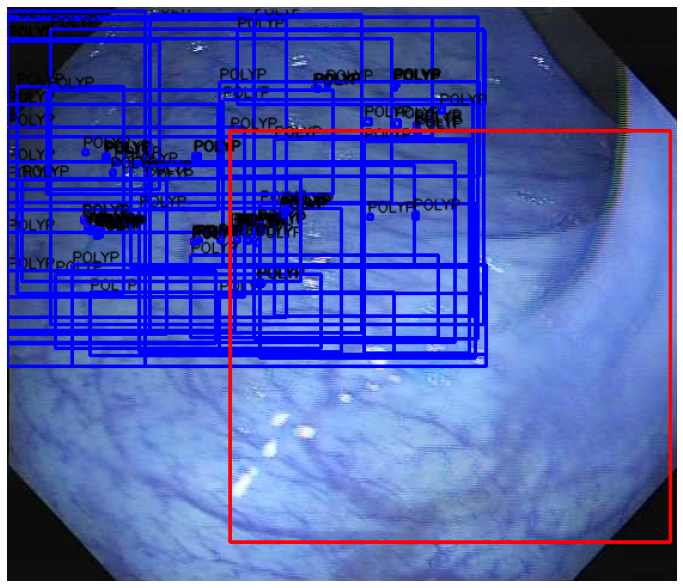

In [21]:
# For Training
images,targets = next(iter(train_loader))
images = list(map(lambda img: img.to(device), images))
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400).to(device), torch.rand(3, 500, 400).to(device)]
predictions = model(x)           # Returns predictions

# Reconstruct the image
imgIndex = int(targets[0]['imgIndex'].cpu().detach().numpy())
img = cv2.imread(trainData.iloc[imgIndex, 0])
dispImage(img, predictions[0], targets[0])

# Train the Model

In [22]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

In [ ]:
from torch.optim.lr_scheduler import StepLR
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=20)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, valid_loader, device=device)

print("That's it!")
    



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [  0/140]  eta: 0:07:31  lr: 0.000041  loss: 0.8292 (0.8292)  loss_classifier: 0.6909 (0.6909)  loss_box_reg: 0.0922 (0.0922)  loss_objectness: 0.0401 (0.0401)  loss_rpn_box_reg: 0.0059 (0.0059)  time: 3.2235  data: 2.0472  max mem: 8550
Epoch: [0]  [ 20/140]  eta: 0:02:26  lr: 0.000760  loss: 0.3345 (0.4422)  loss_classifier: 0.1540 (0.2843)  loss_box_reg: 0.0893 (0.0905)  loss_objectness: 0.0496 (0.0624)  loss_rpn_box_reg: 0.0049 (0.0051)  time: 1.1198  data: 0.0101  max mem: 8818
Epoch: [0]  [ 40/140]  eta: 0:01:57  lr: 0.001478  loss: 0.2305 (0.3410)  loss_classifier: 0.0978 (0.1984)  loss_box_reg: 0.0846 (0.0891)  loss_objectness: 0.0340 (0.0491)  loss_rpn_box_reg: 0.0035 (0.0043)  time: 1.1272  data: 0.0094  max mem: 8818
Epoch: [0]  [ 60/140]  eta: 0:01:33  lr: 0.002197  loss: 0.2101 (0.2986)  loss_classifier: 0.0763 (0.1589)  loss_box_reg: 0.1131 (0.0967)  loss_objectness: 0.0125 (0.0392)  loss_rpn_box_reg: 0.0024 (0.0038)  time: 1.1538  data: 0.0122  max mem: 8818


In [ ]:
# For Testing
images,targets = next(iter(valid_loader))
images = list(map(lambda img: img.to(device), images))
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
model.eval()
predictions = model(images)   # Returns losses and detections

In [ ]:
for i in range(len(images)):
  # Reconstruct the image
  imgIndex = int(targets[i]['imgIndex'].cpu().detach().numpy())
  img = cv2.imread(trainData.iloc[imgIndex, 0])
  dispImage(img, predictions[i], targets[i])